In [5]:
from pathlib import Path

data_dir = Path("data")

def filter_path(path):
    return (path.parent.stem != ".ipynb_checkpoints"
        and "week7" not in str(path)
        and "week8" not in str(path))

data_paths = sorted(filter(filter_path, data_dir.glob("**/*.csv")))
data_paths

[WindowsPath('data/week10/1005BLINKS1.csv'),
 WindowsPath('data/week10/1005BLINKS2.csv'),
 WindowsPath('data/week10/1005BLINKS3.csv'),
 WindowsPath('data/week10/1005BLINKS4.csv'),
 WindowsPath('data/week10/1005BLINKS5.csv'),
 WindowsPath('data/week10/1005BLINKS6.csv'),
 WindowsPath('data/week11/0510blink1.csv'),
 WindowsPath('data/week11/0510blinK10.csv'),
 WindowsPath('data/week11/0510blink2.csv'),
 WindowsPath('data/week11/0510blink3.csv'),
 WindowsPath('data/week11/0510blink4.csv'),
 WindowsPath('data/week11/0510blink5.csv'),
 WindowsPath('data/week11/0510blinK6.csv'),
 WindowsPath('data/week11/0510blinK7.csv'),
 WindowsPath('data/week11/0510blinK8.csv'),
 WindowsPath('data/week11/0510blinK9.csv'),
 WindowsPath('data/week11/0510DOUBLEBLINK01.csv'),
 WindowsPath('data/week11/0510LEFT01.csv'),
 WindowsPath('data/week11/0510LEFT02.csv'),
 WindowsPath('data/week11/0510LEFT03.csv'),
 WindowsPath('data/week11/0510RIGHT01.csv'),
 WindowsPath('data/week11/0510RIGHT02.csv'),
 WindowsPath('da

In [6]:
import numpy as np

def load_data(path, with_laps="laps.txt", reverse=True):
    laps = []
    if with_laps:
        name = path.stem
        found = False
        laps_txt = path.parent / with_laps
        if laps_txt.exists():
            with open(laps_txt) as f:
                for line in f.readlines():
                    line = line.strip()
                    if not line:
                        pass
                    elif not line.replace(".", "").isnumeric():
                        if found:
                            break
                        if name == line:
                            found = True
                    elif found:
                        laps.append(float(line))
                laps = np.cumsum(np.array(laps))
    arr = np.genfromtxt(path, delimiter=",")
    time, amp = arr.T
    if time[-1] < time[0]:
        time = np.max(time) - time
        amp = amp[::-1]

    return time, amp, laps if len(laps) else None

In [7]:
import matplotlib.pyplot as plt

def plot_data(time, amp, laps=None, /, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(time, amp)
    if laps is not None:
        ax.vlines(laps, np.min(amp), np.max(amp),
                  color="red")

In [8]:
from tqdm.auto import tqdm

figure_dir = Path("figure/raw")

for path in tqdm(data_paths):
    fig, ax = plt.subplots(figsize=(12, 4))
    time, amp, laps = load_data(path)
    plot_data(time, amp, laps)
    ax.set_title(path.stem)
    where = figure_dir / path.relative_to(data_dir).with_suffix(".png")
    where.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(where)
    plt.close()

  0%|          | 0/48 [00:00<?, ?it/s]

In [9]:
from tqdm.auto import tqdm

figure_dir = Path("figure/week11/")
week11_paths = list(filter(lambda path: "week11" in str(path), data_paths))

for path in tqdm(week11_paths):
    fig, ax = plt.subplots(figsize=(12, 4))
    time, amp, laps = load_data(path)
    plot_data(time, amp, laps)
    plt.hlines(625, 0, np.max(time), color="r")
    ax.set_title(path.stem)
    where = figure_dir / path.relative_to(data_dir).with_suffix(".png")
    where.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(where)
    plt.close()

  0%|          | 0/17 [00:00<?, ?it/s]

## Event Detection

### Moving Average of Absolute Difference

In [10]:
from scipy.signal import find_peaks

figure_dir = Path("figure/prominence_50/")

for path in tqdm(data_paths):
    window_sec = 1.0
    window_n = int(10_000 * window_sec)
    
    time, amp, laps = load_data(path)
    
    amp_mean = np.mean(amp)
    abs_diff = np.r_[0, np.abs(np.diff(amp))]
    moving_avg = np.convolve(abs_diff, np.ones(window_n), "full")[:-(window_n - 1)] / window_n
    high_peaks, _ = find_peaks(amp - amp_mean, prominence=50)
    low_peaks, _ = find_peaks(amp_mean - amp, prominence=50)
    
    fig = plt.figure(figsize=(12, 4))
    plot_data(time, amp)
    plot_data(time, np.where(moving_avg > 0.02, max(amp), min(amp)))
    plt.scatter(time[high_peaks], amp[high_peaks], c="green", marker="x")
    plt.scatter(time[low_peaks], amp[low_peaks], c="red", marker="x")
    
    where = figure_dir / path.relative_to(data_dir).with_suffix(".png")
    where.parent.mkdir(parents=True, exist_ok=True)    
    fig.savefig(where)
    plt.close()

  0%|          | 0/48 [00:00<?, ?it/s]

### Variance

In [11]:
from scipy.signal import find_peaks

figure_dir = Path("figure/prominence_90/")

for path in tqdm(data_paths):
    window_sec = 1.0
    window_n = int(10_000 * window_sec)
    
    time, amp, laps = load_data(path)
    
    amp_med = np.median(amp)
    error = amp - amp_med
    std = np.convolve(error ** 2, np.ones(window_n), "full")[:-(window_n - 1)] / window_n
    high_peaks, _ = find_peaks(amp - amp_mean, prominence=90)
    low_peaks, _ = find_peaks(amp_mean - amp, prominence=90)
    
    fig = plt.figure(figsize=(12, 4))
    plot_data(time, amp)
    plot_data(time, np.where(std > 150, max(amp), min(amp)))
    plt.scatter(time[high_peaks], amp[high_peaks], c="green", marker="x")
    plt.scatter(time[low_peaks], amp[low_peaks], c="red", marker="x")
    
    where = figure_dir / path.relative_to(data_dir).with_suffix(".png")
    where.parent.mkdir(parents=True, exist_ok=True)    
    fig.savefig(where)
    plt.close()

  0%|          | 0/48 [00:00<?, ?it/s]

### Windowed Visualization

In [12]:
def sliding_window(time,
                   amp,
                   laps=None,
                   window_sec=1.0,
                   window_inc=0.2,
                   show_progress=True):
    n_window = int((max(time) - window_sec) // window_inc)
    iter_window = range(n_window)
    if show_progress:
        from tqdm.auto import tqdm
        iter_window = tqdm(iter_window, leave=False)
    for i in iter_window:
        start_sec = window_inc * i
        end_sec = start_sec + window_sec
        mask = (start_sec <= time) & (time < end_sec)
        if laps is not None:
            laps_masked = laps[(start_sec <= laps) & (laps < end_sec)]
            yield time[mask], amp[mask], laps_masked
        else:
            yield time[mask], amp[mask], None

# windows = sliding_window(time, amp, laps)
# for _ in range(25):
#     next(windows)
# window_time, window_amp, window_laps = next(windows)
# plt.figure(figsize=(12, 4))
# plot_data(window_time, window_amp, window_laps)
# plt.show()

In [13]:
import pandas as pd
from tqdm.auto import tqdm
from tsfeatures import acf_features

df_acf = pd.DataFrame()
for path in filter(lambda path: any(keyword in str(path)
                                    for keyword in ("week6", "week9")),
                   tqdm(data_paths)):
    time, amp, laps = load_data(path)
    feat = [acf_features(amp) for _, amp, _ in sliding_window(time, amp)]
    df_acf = pd.concat([df_acf, pd.DataFrame(feat)], ignore_index=True)

df_acf.to_csv("data/week6_9_acf.csv")

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X = df_acf.to_numpy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

clustering = KMeans(n_clusters=3)
y = clustering.fit_predict(X_scaled)
np.unique(y, return_counts=True)

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

(array([0, 1, 2]), array([ 328,    2, 2620], dtype=int64))

In [14]:
def predict_event(time, amp,
                  event_classifier,
                  window_sec=1.2,
                  window_inc=0.05,
                  event_skip=None):
    if event_skip is None:
        event_skip = int(window_sec // window_inc)
    windows = sliding_window(time, amp)
    while (window := next(windows, None)) is not None:
        window_time, window_amp, _ = window
        has_event = event_classifier(window_amp)
        if has_event:
            yield min(window_time), max(window_time)
            for _ in range(event_skip):
                next(windows, None)

  0%|          | 0/94 [00:00<?, ?it/s]

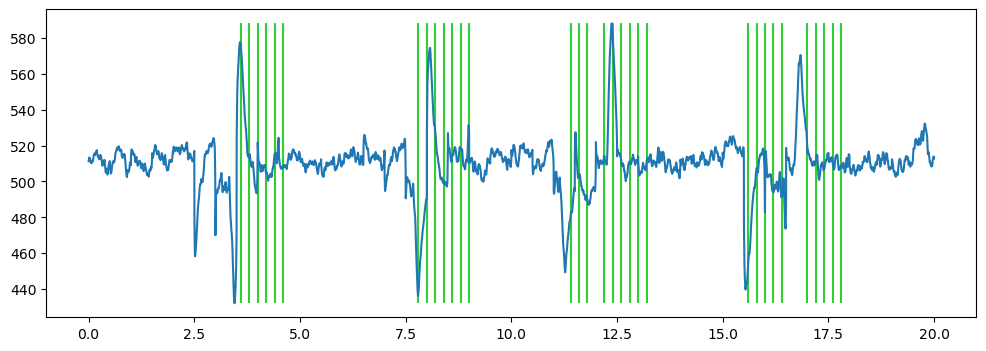

In [15]:
def classifier(amp):
    return np.var(amp) > 250

time, amp, laps = load_data(Path("./data/week9/2204looklefts1.csv"))

threshold = np.std(amp)

events = [*predict_event(time, amp,
                         classifier,
                         window_sec=1.0,
                         window_inc=0.1,
                         event_skip=0)]
plt.figure(figsize=(12, 4))
for event_start, event_end in events:
    plt.vlines(event_end, min(amp), max(amp), color="limegreen")
plot_data(time, amp, laps)
plt.show()

## Event Classficiation

### Slice

In [21]:
import re
import pandas as pd
from tqdm.auto import tqdm

clip_df = []
for path in tqdm(data_paths):
    week = int(re.search(r"week(\d+)", str(path), flags=re.I).group(1))
    for s in ("left", "right", "blink", "no", "test"):
        if s in str(path).lower():
            label = s
            break
    else:
        raise ValueError()

    double = "double" in str(path)

    window_sec = 1.0
    window_n = int(10_000 * window_sec)
    minimum_sec = 0.2
    minimum_n = int(10_000 * minimum_sec)
    
    time, amp, laps = load_data(path)
    
    amp_med = np.median(amp)
    error = amp - amp_med
    std = np.convolve(error ** 2, np.ones(window_n), "full")[:-(window_n - 1)] / window_n
    event = (std > 150).astype(int)
    for i, j in np.where(np.diff(np.r_[0, event, 0]))[0].reshape(-1, 2):
        if j - i < minimum_n:
            continue
        clip_time = time[max(0, i - window_n):j]
        clip_amp = amp[max(0, i - window_n):j]
        clip_df.append({
            "week": week,
            "path": str(path),
            "label": label,
            "double": double,
            "time": clip_time,
            "amp": clip_amp,
        })

clip_df = pd.DataFrame(clip_df)

  0%|          | 0/48 [00:00<?, ?it/s]

### Blink vs Not Blink

The method used here is the minimum difference in indicies between peaks (high or low).

_20,000 indicies = 1 second_

In [22]:
from scipy.signal import find_peaks

tqdm.pandas()

def clip_features(amp):
    high_peaks, _ = find_peaks(amp, prominence=50)
    low_peaks, _ = find_peaks(-amp, prominence=50)
    peaks = np.sort(np.concatenate([high_peaks, low_peaks]))
    min_diff_peak = np.min(np.diff(peaks)) if len(peaks) > 1 else 0
    return {
        "min_diff_peak": min_diff_peak,
        "len_peak": len(peaks)
    }

clip_good_df = clip_df[((clip_df["week"].isin([6, 9, 10, 11])))
    & (~clip_df["label"].isin(["test", "no"]))].reset_index()
clip_feat = pd.DataFrame([*clip_good_df["amp"].progress_apply(clip_features)])
clip_feat_df = clip_good_df.drop(columns=["time", "amp"]).join(clip_feat)
clip_feat_df

  0%|          | 0/256 [00:00<?, ?it/s]

,index,week,path,label,double,min_diff_peak,len_peak
0,0,10,data\week10\1005BLINKS1.csv,blink,False,0,1
1,1,10,data\week10\1005BLINKS1.csv,blink,False,1571,2
2,2,10,data\week10\1005BLINKS1.csv,blink,False,0,1
3,3,10,data\week10\1005BLINKS1.csv,blink,False,0,1
4,4,10,data\week10\1005BLINKS1.csv,blink,False,1312,2
...,...,...,...,...,...,...,...
251,251,9,data\week9\double\right\2204doubleright.csv,right,True,727,7
252,252,9,data\week9\double\right\2204doubleright.csv,right,True,3433,4
253,253,9,data\week9\double\right\2204doubleright.csv,right,True,202,7
254,254,9,data\week9\double\right\2204doubleright1.csv,right,True,446,8


In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

X = clip_feat_df.iloc[:, 5:].to_numpy()
y = (clip_feat_df["label"] == "blink").to_numpy()

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []
for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]

    model = DecisionTreeClassifier(max_depth=2, class_weight="balanced")
    model.fit(X_train, y_train)
    scores.append(accuracy_score(y_test, model.predict(X_test)))

print(f"k-fold score: {np.mean(scores):.1%}")

k-fold score: 81.6%


In [29]:
from scipy.signal import find_peaks
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

tqdm.pandas()

def clip_features(amp, prominence):
    high_peaks, _ = find_peaks(amp, prominence=prominence)
    low_peaks, _ = find_peaks(-amp, prominence=prominence)
    peaks = np.sort(np.concatenate([high_peaks, low_peaks]))
    min_diff_peak = np.min(np.diff(peaks)) if len(peaks) > 1 else 0
    return {
        "min_diff_peak": min_diff_peak,
        "len_peak": len(peaks)
    }

clip_good_df = clip_df[(clip_df["week"].isin([6, 9, 10, 11]))
                       & (~clip_df["label"].isin(["test", "no"]))].reset_index()

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = DecisionTreeClassifier(max_depth=2, class_weight="balanced")


prominence_values = range(0, 101, 5)
prominence_scores = []

for prominence in prominence_values:
    clip_feat = pd.DataFrame([*clip_good_df["amp"].progress_apply(clip_features, prominence=prominence)])
    clip_feat_df = clip_good_df.drop(columns=["time", "amp"]).join(clip_feat)

    X = clip_feat_df.iloc[:, 5:].to_numpy()
    y = (clip_feat_df["label"] == "blink").to_numpy()

    scores = []
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        scores.append(accuracy_score(y_test, model.predict(X_test)))

    mean_score = np.mean(scores)
    prominence_scores.append((prominence, mean_score))
    print(f"Prominence {prominence}: {mean_score:.1%}")



  0%|          | 0/256 [00:00<?, ?it/s]

Prominence 0: 65.6%


  0%|          | 0/256 [00:00<?, ?it/s]

Prominence 5: 66.4%


  0%|          | 0/256 [00:00<?, ?it/s]

Prominence 10: 69.1%


  0%|          | 0/256 [00:00<?, ?it/s]

Prominence 15: 75.0%


  0%|          | 0/256 [00:00<?, ?it/s]

Prominence 20: 76.1%


  0%|          | 0/256 [00:00<?, ?it/s]

Prominence 25: 79.7%


  0%|          | 0/256 [00:00<?, ?it/s]

Prominence 30: 78.1%


  0%|          | 0/256 [00:00<?, ?it/s]

Prominence 35: 77.3%


  0%|          | 0/256 [00:00<?, ?it/s]

Prominence 40: 76.9%


  0%|          | 0/256 [00:00<?, ?it/s]

Prominence 45: 78.1%


  0%|          | 0/256 [00:00<?, ?it/s]

Prominence 50: 81.6%


  0%|          | 0/256 [00:00<?, ?it/s]

Prominence 55: 81.6%


  0%|          | 0/256 [00:00<?, ?it/s]

Prominence 60: 80.9%


  0%|          | 0/256 [00:00<?, ?it/s]

Prominence 65: 82.0%


  0%|          | 0/256 [00:00<?, ?it/s]

Prominence 70: 83.2%


  0%|          | 0/256 [00:00<?, ?it/s]

Prominence 75: 81.2%


  0%|          | 0/256 [00:00<?, ?it/s]

Prominence 80: 80.1%


  0%|          | 0/256 [00:00<?, ?it/s]

Prominence 85: 78.9%


  0%|          | 0/256 [00:00<?, ?it/s]

Prominence 90: 78.9%


  0%|          | 0/256 [00:00<?, ?it/s]

Prominence 95: 79.7%


  0%|          | 0/256 [00:00<?, ?it/s]

Prominence 100: 78.9%


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

    Prominence  Accuracy
0            0  0.656259
1            5  0.663876
2           10  0.691327
3           15  0.749698
4           20  0.761388
5           25  0.796757
6           30  0.781071
7           35  0.773228
8           40  0.769231
9           45  0.780995
10          50  0.816214
11          55  0.816214
12          60  0.808522
13          65  0.820136
14          70  0.831976
15          75  0.812293
16          80  0.800679
17          85  0.788914
18          90  0.788989
19          95  0.796833
20         100  0.788914


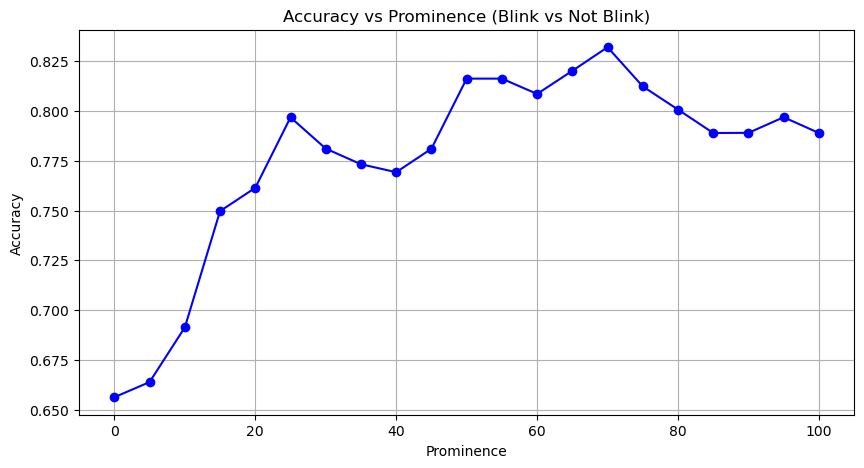

In [37]:
from scipy.signal import find_peaks
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import StratifiedKFold

tqdm.pandas()

def clip_features(amp, prominence):
    high_peaks, _ = find_peaks(amp, prominence=prominence)
    low_peaks, _ = find_peaks(-amp, prominence=prominence)
    peaks = np.sort(np.concatenate([high_peaks, low_peaks]))
    min_diff_peak = np.min(np.diff(peaks)) if len(peaks) > 1 else 0
    return {
        "min_diff_peak": min_diff_peak,
        "len_peak": len(peaks)
    }

clip_good_df = clip_df[(clip_df["week"].isin([6, 9, 10, 11]))
                       & (~clip_df["label"].isin(["test", "no"]))].reset_index()

# Prepare the model
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = DecisionTreeClassifier(max_depth=2, class_weight="balanced")

prominence_values = range(0, 101, 5)
results = []

for prominence in prominence_values:
    clip_feat = pd.DataFrame([*clip_good_df["amp"].progress_apply(clip_features, prominence=prominence)])
    clip_feat_df = clip_good_df.drop(columns=["time", "amp"]).join(clip_feat)

    X = clip_feat_df.iloc[:, 5:].to_numpy()
    y = (clip_feat_df["label"] == "blink").to_numpy()

    scores = []
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        scores.append(accuracy_score(y_test, model.predict(X_test)))

    mean_score = np.mean(scores)
    results.append((prominence, mean_score))

results_df = pd.DataFrame(results, columns=["Prominence", "Accuracy"])
print(results_df)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(results_df["Prominence"], results_df["Accuracy"], marker='o', linestyle='-', color='blue')
plt.xlabel('Prominence')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Prominence (Blink vs Not Blink)')
plt.grid(True)
plt.show()


score: 85.1%


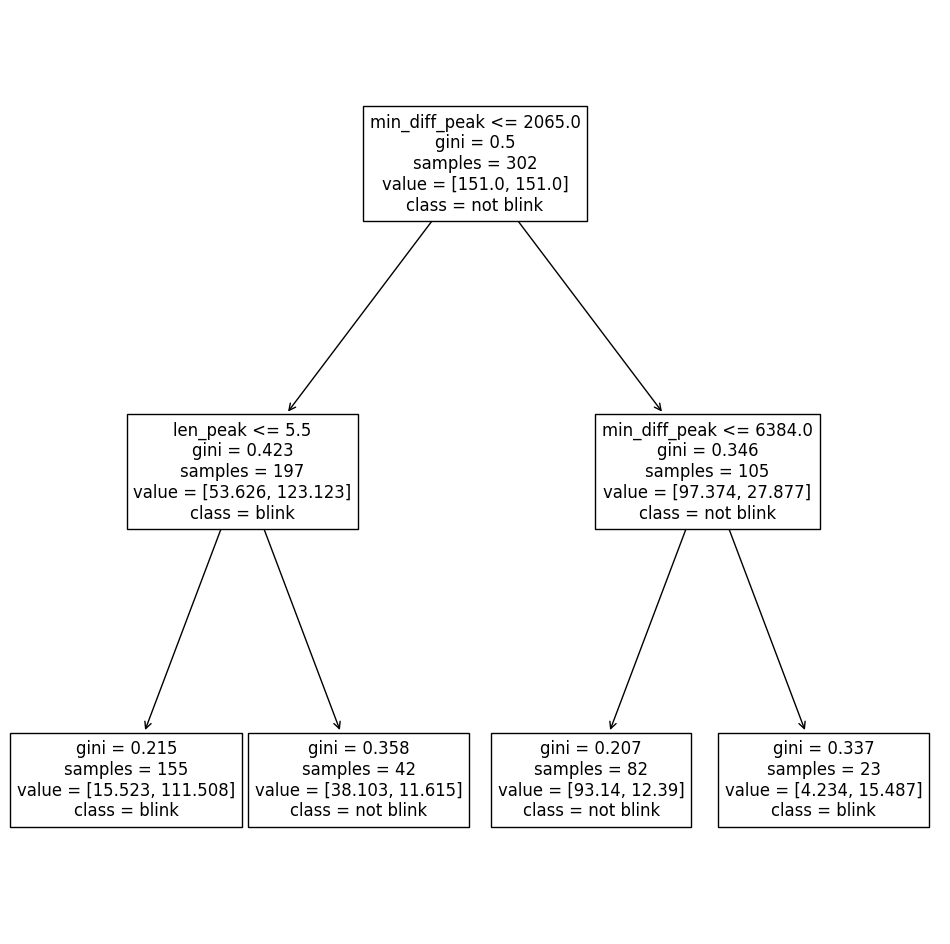

In [1076]:
X = clip_feat_df.iloc[:, 5:].to_numpy()
y = (clip_feat_df["label"] == "blink").to_numpy()

model = blink_dt = DecisionTreeClassifier(max_depth=2, class_weight="balanced")
model.fit(X, y)

print(f"score: {model.score(X, y):.1%}")

# print(f"coef: {model.coef_}, intercept: {model.intercept_}")
# intercept = 10
# slope = -0.0025
# plt.scatter(*X.T, c=y)
# plt.axline((0, intercept), slope=slope)
# plt.show()

plt.figure(figsize=(12, 12))
plot_tree(model,
          feature_names=clip_feat_df.columns[5:],
          class_names=["not blink", "blink"])
plt.savefig("blink_classifier.png")
plt.show()

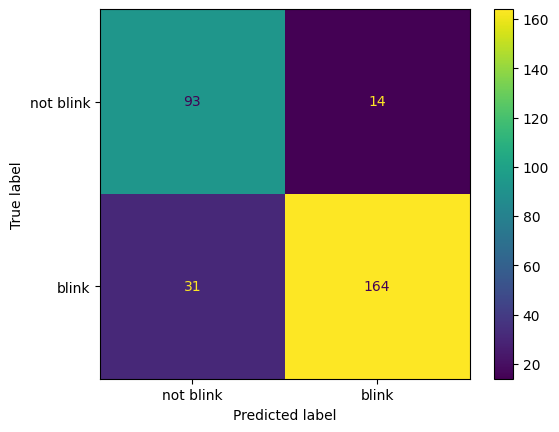

In [1004]:
cm = confusion_matrix(y, model.predict(X))
ConfusionMatrixDisplay(cm, display_labels=["not blink", "blink"]).plot()
plt.show()

### Left vs Right

accuracy score: 90.5%


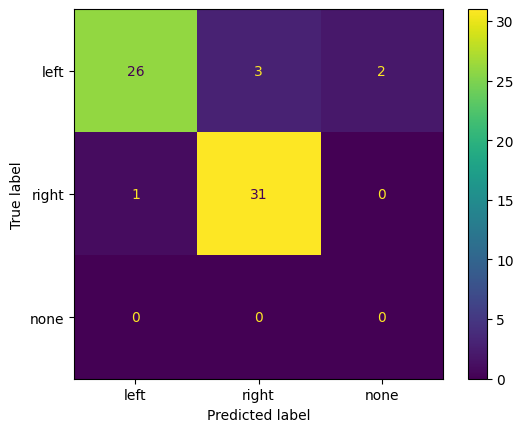

In [617]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix

clip_lr_df = clip_df[(clip_df["week"].isin([9, 10, 11]))
    & (~clip_df["label"].isin(["test", "no"]))
    & (~clip_df["double"])
    & (clip_df["label"].isin(["left", "right"]))].reset_index()

# the nodes are swapped in some weeks
clip_lr_df.loc[clip_lr_df["week"].isin([6]), "label"] = \
    clip_lr_df.loc[clip_lr_df["week"].isin([6]), "label"].map(
        {"left": "right", "right": "left"}.get)

amps = clip_lr_df[["amp"]]
label = clip_lr_df["label"].astype("category")

def lr_classify(amp):
    high_peaks, _ = find_peaks(amp, prominence=50)
    low_peaks, _ = find_peaks(-amp, prominence=50)
    if len(high_peaks) and len(low_peaks):
        return ["left", "right"][int(np.mean(high_peaks) < np.mean(low_peaks))]
    else:
        return "none"

prediction = amps.map(lr_classify).astype("category")

print(f"accuracy score: {accuracy_score(label, prediction):.1%}")
cm = confusion_matrix(label, prediction, labels=["left", "right", "none"])
ConfusionMatrixDisplay(cm, display_labels=["left", "right", "none"]).plot()
plt.show()

    Prominence  Accuracy
0            0  0.428571
1            5  0.523810
2           10  0.476190
3           15  0.460317
4           20  0.698413
5           25  0.793651
6           30  0.809524
7           35  0.873016
8           40  0.904762
9           45  0.904762
10          50  0.904762
11          55  0.888889
12          60  0.920635
13          65  0.873016
14          70  0.888889
15          75  0.841270
16          80  0.777778
17          85  0.698413
18          90  0.666667
19          95  0.650794
20         100  0.603175


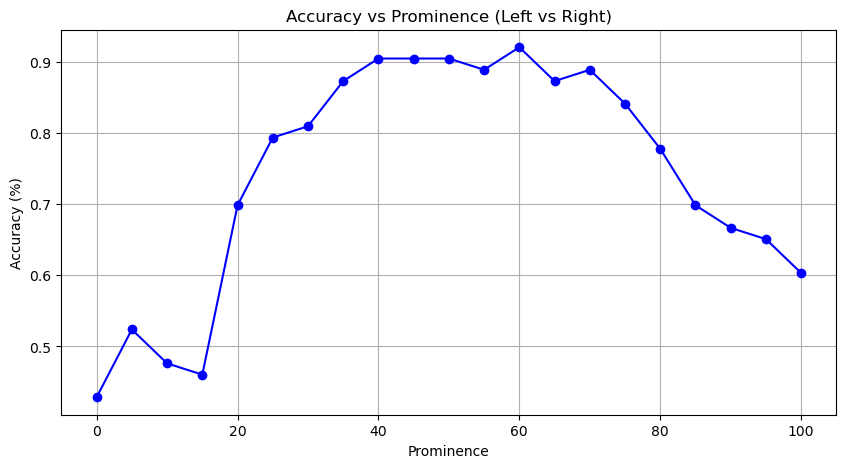

In [38]:
from scipy.signal import find_peaks
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score


clip_lr_df = clip_df[(clip_df["week"].isin([9, 10, 11]))
                     & (~clip_df["label"].isin(["test", "no"]))
                     & (~clip_df["double"])
                     & (clip_df["label"].isin(["left", "right"]))].reset_index()


clip_lr_df.loc[clip_lr_df["week"].isin([6]), "label"] = \
    clip_lr_df.loc[clip_lr_df["week"].isin([6]), "label"].map(
        {"left": "right", "right": "left"}.get)


def lr_classify(amp, prominence):
    high_peaks, _ = find_peaks(amp, prominence=prominence)
    low_peaks, _ = find_peaks(-amp, prominence=prominence)
    if len(high_peaks) > 0 and len(low_peaks) > 0:
        return "right" if np.mean(high_peaks) < np.mean(low_peaks) else "left"
    return "none"


prominence_values = range(0, 101, 5)
results = []

for prominence in prominence_values:
    prediction = clip_lr_df["amp"].apply(lr_classify, prominence=prominence).astype("category")
    accuracy = accuracy_score(clip_lr_df["label"], prediction)
    results.append((prominence, accuracy))

results_df = pd.DataFrame(results, columns=["Prominence", "Accuracy"])
print(results_df)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(results_df["Prominence"], results_df["Accuracy"], marker='o', linestyle='-', color='blue')
plt.xlabel('Prominence')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Prominence (Left vs Right)')
plt.grid(True)
plt.show()


### Single vs Double

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix

clip_dbl_df = clip_df[(clip_df["week"].isin([9, 10, 11]))
    & (~clip_df["label"].isin(["test", "no"]))].reset_index()

def dbl_features(amp):
    high_peaks, _ = find_peaks(amp, prominence=50)
    low_peaks, _ = find_peaks(-amp, prominence=50)
    peaks = np.sort(np.concatenate([high_peaks, low_peaks]))
    return {
        "len": len(amp),
        "n_peak": len(peaks)
    }

clip_dbl_feat = pd.DataFrame([*clip_dbl_df["amp"].progress_apply(dbl_features)])
clip_dbl_feat_df = clip_dbl_df.drop(columns=["time", "amp"]).join(clip_dbl_feat)
clip_dbl_feat_df

  0%|          | 0/204 [00:00<?, ?it/s]

,index,week,path,label,double,len,n_peak
0,0,10,data\week10\1005BLINKS1.csv,blink,False,13633,1
1,1,10,data\week10\1005BLINKS1.csv,blink,False,18306,2
2,2,10,data\week10\1005BLINKS1.csv,blink,False,19781,1
3,3,10,data\week10\1005BLINKS1.csv,blink,False,20012,1
4,4,10,data\week10\1005BLINKS1.csv,blink,False,20089,2
...,...,...,...,...,...,...,...
199,251,9,data\week9\double\right\2204doubleright.csv,right,True,39606,7
200,252,9,data\week9\double\right\2204doubleright.csv,right,True,38246,4
201,253,9,data\week9\double\right\2204doubleright.csv,right,True,38340,7
202,254,9,data\week9\double\right\2204doubleright1.csv,right,True,39440,8


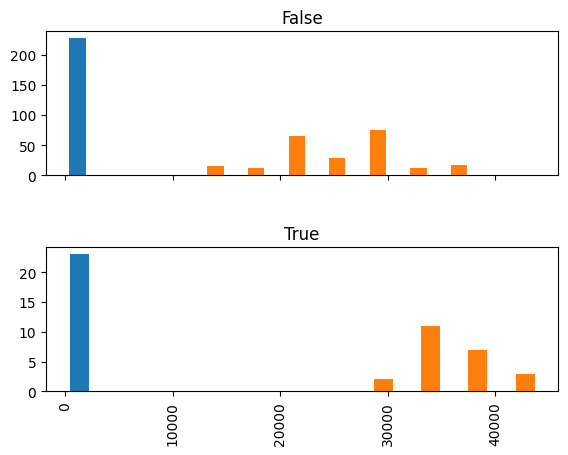

In [566]:
clip_dbl_feat_df[["double", "len"]].hist(by="double", sharex=True, layout=[2, 1])
plt.show()

In [570]:
X = clip_dbl_feat_df.iloc[:, 5:].to_numpy()
y = clip_dbl_feat_df["double"].to_numpy()

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []
for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]

    model = DecisionTreeClassifier(max_depth=1, class_weight="balanced")
    model.fit(X_train, y_train)
    scores.append(accuracy_score(y_test, model.predict(X_test)))

print(f"k-fold score: {np.mean(scores):.1%}")

k-fold score: 92.8%


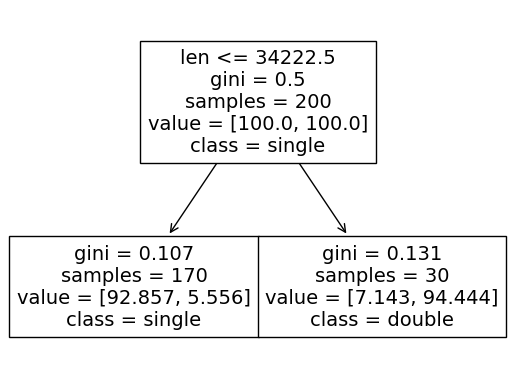

In [575]:
plot_tree(model,
          feature_names=clip_dbl_feat_df.columns[5:],
          class_names=["single", "double"])
plt.show()

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

    Prominence  Accuracy
0            0  0.896829
1            5  0.901585
2           10  0.906463
3           15  0.925976
4           20  0.911341
5           25  0.911341
6           30  0.911341
7           35  0.911341
8           40  0.911341
9           45  0.911341
10          50  0.911341
11          55  0.911341
12          60  0.911341
13          65  0.862561
14          70  0.892073
15          75  0.896707
16          80  0.877195
17          85  0.877195
18          90  0.896707
19          95  0.882073
20         100  0.891829


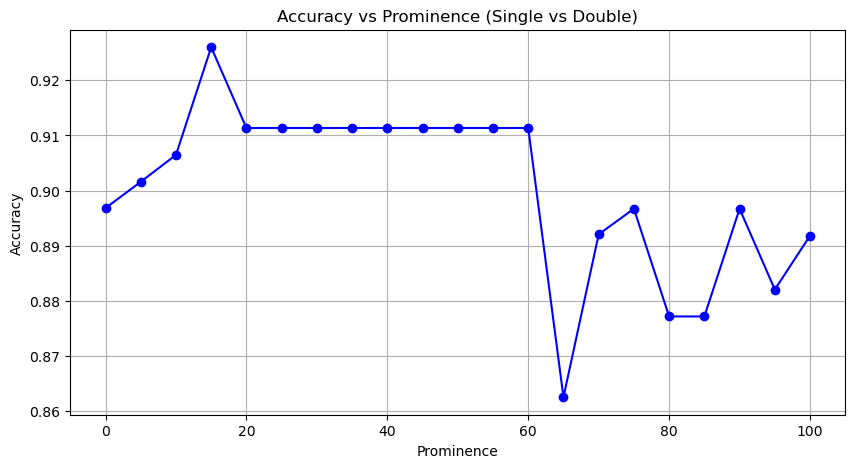

In [44]:
from scipy.signal import find_peaks
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

def dbl_features(amp, prominence):
    high_peaks, _ = find_peaks(amp, prominence=prominence)
    low_peaks, _ = find_peaks(-amp, prominence=prominence)
    peaks = np.sort(np.concatenate([high_peaks, low_peaks]))
    return {
        "len": len(amp),
        "n_peak": len(peaks)
    }

clip_good_df = clip_df[(clip_df["week"].isin([6, 9, 10, 11]))
                       & (~clip_df["label"].isin(["test", "no"]))].reset_index()

prominence_values = range(0, 101, 5)
results = []

for prominence in prominence_values:

    clip_dbl_feat = pd.DataFrame([*clip_dbl_df["amp"].progress_apply(dbl_features, prominence=prominence)])
    clip_dbl_feat_df = clip_dbl_df.drop(columns=["time", "amp"]).join(clip_dbl_feat)

    X = clip_dbl_feat_df.iloc[:, 5:].to_numpy()
    y = clip_dbl_feat_df["double"].to_numpy()

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_index, test_index in kf.split(X, y):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]

        model = DecisionTreeClassifier(max_depth=1, class_weight="balanced")
        model.fit(X_train, y_train)
        scores.append(accuracy_score(y_test, model.predict(X_test)))

    mean_score = np.mean(scores)
    results.append((prominence, mean_score))

results_df = pd.DataFrame(results, columns=["Prominence", "Accuracy"])
print(results_df)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(results_df["Prominence"], results_df["Accuracy"], marker='o', linestyle='-', color='blue')
plt.xlabel('Prominence')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Prominence (Single vs Double)')
plt.grid(True)
plt.show()


### Combined

accuracy score: 61.8%


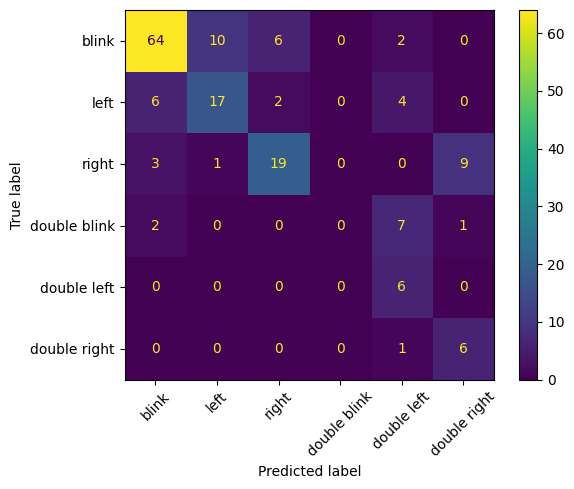

In [1085]:
from sklearn.metrics import balanced_accuracy_score

def classify(event):
    high_peaks, _ = find_peaks(event, prominence=50)
    low_peaks, _ = find_peaks(-event, prominence=50)
    if len(high_peaks) == 0 or len(low_peaks) == 0:
        return "no"
    peaks = np.sort(np.concatenate((high_peaks, low_peaks)))
    min_diff_peak = np.min(np.diff(peaks))
    if blink_dt.predict([[min_diff_peak, len(peaks)]]):
        movement = "blink"
    else:
        if np.mean(high_peaks) > np.mean(low_peaks):
            movement = "left"
        else:
            movement = "right"
    if len(event) > 34222.5:
        movement = f"double {movement}"
    return movement

clip_comb_df = clip_df[(clip_df["week"].isin([9, 11]))
    & (~clip_df["label"].isin(["test", "no"]))].reset_index()

# the nodes are swapped in some weeks
clip_comb_df.loc[clip_comb_df["week"].isin([6]), "label"] = \
    clip_comb_df.loc[clip_comb_df["week"].isin([6]), "label"].map(
        {"blink": "blink", "left": "right", "right": "left"}.get)

prediction = clip_comb_df["amp"].map(classify)
label = clip_comb_df.apply(
    lambda row: ("double " if row["double"] else "") + row["label"],
    axis=1
)

print(f"accuracy score: {balanced_accuracy_score(label, prediction):.1%}")

cm = confusion_matrix(label, prediction, labels=label.unique())
ConfusionMatrixDisplay(cm, display_labels=label.unique()).plot()
plt.xticks(rotation=45)
plt.savefig("confmat.png", bbox_inches="tight")
plt.show()